# Deriving a vegetation index from PlanetScope imagery

Researchers often use a vegetation index called NDVI to measure the "greeenness" or density of vegetation across a landscape. In addition to monitoring vegetation health, NDVI (Normalized Difference Vegetation Index), can be used to track climate change, agricultural production, desertification, fire prediction, and land cover change. Developed by a NASA scientist Compton Tucker in 1977, NDVI is derived from satellite imagery and compares reflected near-infrared light to reflected visible red light. It is expressed as the following equation:

![ndvi-equation.png](ndvi-equation.png)

In general, healthy and/or dense vegetation reflects more near-infrared light than red visible light. Conversely, when vegetation is sparse or not-so-healthy, we see a decrease in near-infrared reflectance and an increase in red reflectance. You can read more about how NDVI is used to study cyclical, seasonal, and long-term changes in plant health and climate from [NASA researchers](https://earthobservatory.nasa.gov/Features/MeasuringVegetation/measuring_vegetation_1.php) and from [USGS researchers](https://phenology.cr.usgs.gov/ndvi_foundation.php). 

**In this guide, we'll walk you through a several-step process of using Python's numpy library to perform a basic NDVI calculation on PlanetScope 4-band imagery:**

1. Download a 4-Band image
2. Extract the Visible Red, and NIR bands
3. Normalize to Top of Atmosphere Reflectance
4. Perform the NDVI calculation
5. Save the NDVI image
6. Apply a color map
7. Generate a histogram of NDVI values 

### Requirements
- Python 2.7 or 3+
- [Planet's Python Client](https://www.planet.com/docs/api-quickstart-examples/cli/)
- rasterio
- numpy
- matplotlib
- A Planet API Key, stored as environment variable `$PL_API_KEY`.
- Planet 4-Band Imagery with the following specificatios: `item-type`: PSOrthoTile, REOrthoTile, PSScene4Band; `asset-type`: analytic, basic_analytic

## Step 1. Download a 4-Band image 

First, we're going to download a 4-band PlanetScope satellite image of agricultural land in California's Central Valley, captured in late August 2016 (id: 20160831_180302_0e26). You can do this using [Planet's Python client](https://www.planet.com/docs/api-quickstart-examples/cli/) to interact with our Data API, or by browsing [Planet Explorer](https://www.planet.com/products/explorer/), filtering for '4 Band PlanetScope scene' (`PSScene4Band`) or 'Planetscope ortho tile' (`PSOrthoTile`), and downloading an `analytic` asset.

Before we download the full image, we can preview a thumbnail of the image via Planet's Data API. (The thumbnails are 256x256 by default, and can be scaled up to 512x512 by passing in a `width` parameter.) 

In [11]:
from IPython.display import Image
Image(url="https://api.planet.com/data/v1/item-types/PSScene4Band/items/20160831_180302_0e26/thumb?width=512")

Next we're going to use the Planet's Python client to download the image. *Note: when you run this command, you'll get a stream of messages in your Jupyter notebook as the client polls the Data API to determine if the image is activated and ready to download.*

In [ ]:
!planet data download --item-type PSScene4Band --asset-type analytic,analytic_xml --string-in id 20160831_180302_0e26

**Congratulations!** You now have two files in your download directory: `20160831_180302_0e26_3B_AnalyticMS.tif` and `20160831_180302_0e26_3B_AnalyticMS_metadata.xml`. 

## Step 2. Extract the Visible and NIR bands 

In this step, we're going to open the raster image we downloaded (the .tif file), extract the data from the red and near-infrared bands, and load the band data into numpy arrays. In PlanetScope 4-band images, the band order is BGRN: (1) Blue, (2) Green, (3) Red, (4) Near-infrared.

In [13]:
import rasterio
import numpy as np

filename = "20160831_180302_0e26_3B_AnalyticMS.tif"

# Load red and NIR bands - note all PlanetScope 4-band images have band order BGRN
with rasterio.open(filename) as src:
    band_red = src.read(3)

with rasterio.open(filename) as src:
    band_nir = src.read(4)

## Step 3. Normalize to Top of Atmosphere Reflectance

We must normalize the values in the bands so that the NDVI calculation yield values in the expected range of -1 to 1. Values closer to 1 indicate a greater density of vegetation or higher level of "greenness."

In [14]:
from xml.dom import minidom

xmldoc = minidom.parse("20160831_180302_0e26_3B_AnalyticMS_metadata.xml")
nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

# XML parser refers to bands by numbers 1-4
coeffs = {}
for node in nodes:
    bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
    if bn in ['1', '2', '3', '4']:
        i = int(bn)
        value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
        coeffs[i] = float(value)
        
# Multiply the band values by the TOA reflectance coefficients
band_red = band_red * coeffs[3]
band_nir = band_nir * coeffs[4]

## Step 4. Perform the NDVI calculation

Next we perform the NDVI calculation through subtraction and division of the pixel values.

In [16]:
# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')

# Calculate NDVI. This is the equation at the top of this guide expressed in code
ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red)


## Step 5. Save the NDVI image 

Finally we output these new pixel values to a new image file, making sure we mirror the GeoTIFF spatial metadata:

In [17]:
# Set spatial characteristics of the output object to mirror the input
kwargs = src.meta
kwargs.update(
    dtype=rasterio.float32,
    count = 1)

# Write band calculations to a new raster file
with rasterio.open('ndvi.tif', 'w', **kwargs) as dst:
        dst.write_band(1, ndvi.astype(rasterio.float32))

## Step 6. Apply a color map

In [18]:
import matplotlib.pyplot as plt
img = plt.imsave("ndvi_cmap.png", ndvi, cmap=plt.cm.RdYlGn)

In [19]:
from IPython.display import HTML 
HTML('<img src="ndvi_cmap.png" width=75%>') 

## 7. Show a histogram of NDVI values

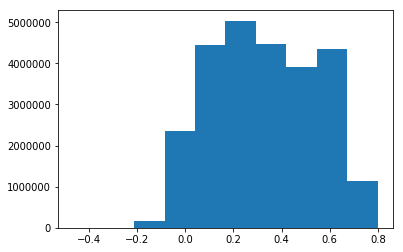

In [20]:
import pylab

pylab.figure()
pylab.hist(ndvi[~np.isnan(ndvi)])
pylab.show()